In [1]:
from google.colab import drive

drive.mount('/content/drive')

%cd drive/MyDrive/Colab Notebooks
#! ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [2]:
!pip install datasets transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00


In [ ]:
# !pip install transformers

In [3]:
import torch

print("Is cuda available?", torch.cuda.is_available())

print("Is cuDNN version:", torch.backends.cudnn.version())

print("cuDNN enabled? ", torch.backends.cudnn.enabled)

print("Device count?", torch.cuda.device_count())

print("Current device?", torch.cuda.current_device())

print("Device name? ", torch.cuda.get_device_name(torch.cuda.current_device()))

x = torch.rand(5, 3)
print(x)

Is cuda available? True
Is cuDNN version: 8700
cuDNN enabled?  True
Device count? 1
Current device? 0
Device name?  Tesla T4
tensor([[0.6162, 0.3486, 0.0062],
        [0.7398, 0.0202, 0.9948],
        [0.8719, 0.7501, 0.7497],
        [0.3670, 0.9250, 0.0323],
        [0.2565, 0.1119, 0.5225]])


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DistilBertModel, DistilBertTokenizer
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

In [ ]:
# Setting up the device for GPU usage
# from torch import cuda

# device = 'cuda' if cuda.is_available() else 'cpu'

**Load and Preprocess data**

In [5]:
df = pd.read_csv('data_model.csv').sample(frac=1)

In [6]:
df.shape

(8712, 26)

In [7]:
df['label'] = df['label'].astype('int')

In [8]:
df_trainA = df.sample(frac=0.7, random_state=44)
df_val_testA = df.drop(df_trainA.index).reset_index(drop=True)
df_valA = df_val_testA.sample(frac=0.5, random_state=44)
df_testA = df_val_testA.drop(df_valA.index).reset_index(drop=True)
df_trainA = df_trainA.reset_index(drop=True)
df_valA = df_valA.reset_index(drop=True)

In [9]:
print(df_trainA.shape, df_valA.shape, df_testA.shape)

(6098, 26) (1307, 26) (1307, 26)


In [10]:
df_trainA.head()

,id,session_log_id,useraccount_id,subject_id,counter,class_id,school_id,is_parent_post,reply_to_post_id,karma_awarded_id,...,is_hidden,is_starred,is_sticky,is_welcome_post,last_poster_permissions,access_permissions,answer_status_flags,ts_created,ts_modified,type
0,49400,552492,526016,1,50399,NaN,11455,0,49388,NaN,...,0,0,NaN,NaN,NaN,4294967295,0,1/14/2014 0:41,1/14/2014 0:42,marginal
1,652044,1703047,1103402,1,633886,NaN,12126,0,652022,NaN,...,0,0,NaN,NaN,NaN,4294967295,0,3/20/2015 1:03,3/20/2015 1:03,safe
2,2797527,23342260,1631643,11,126340,NaN,13245,0,2797415,NaN,...,0,0,NaN,NaN,NaN,4294967295,0,1/18/2019 0:03,1/18/2019 0:03,marginal
3,552995,1258200,1454192,1,538331,NaN,12448,0,552933,NaN,...,0,0,NaN,NaN,NaN,4294967295,0,2/6/2015 1:43,2/6/2015 1:43,marginal
4,1781144,8282987,2405557,1,1634441,NaN,13539,0,1780992,94053.0,...,0,0,NaN,NaN,NaN,4294967295,0,12/7/2016 23:31,12/7/2016 23:33,safe


In [12]:
# df_train = df_trainA[['id', 'comment_text', 'label', 'TOXICITY', 'IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'THREAT', 'SEXUALLY_EXPLICIT']]
# df_val = df_valA[['id', 'comment_text', 'label', 'TOXICITY', 'IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'THREAT', 'SEXUALLY_EXPLICIT']]
# df_train.head()

In [40]:
df_train = df_trainA[['id', 'comment_text', 'label']]
df_val = df_valA[['id', 'comment_text', 'label']]
df_test = df_testA[['id', 'comment_text', 'label']]
df_train.head()

,id,comment_text,label
0,49400,Ok Remember that when you multiply letters wit...,1
1,652044,Its not 48 pounds. You said it is 3 weeks and ...,0
2,2797527,Perhaps a translation but i suck at writing th...,1
3,552995,- mind Process -\n3 * 3... 9 not 6... -facepal...,1
4,1781144,"if you are still there,i hope you understand n...",0


In [14]:
# Define pretrained tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [15]:
print(model.classifier.parameters)

<bound method Module.parameters of Linear(in_features=768, out_features=2, bias=True)>


In [16]:
X_train_tokenized = tokenizer(list(df_train["comment_text"]), padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(list(df_val["comment_text"]), padding=True, truncation=True, max_length=512)

In [17]:
y_train = list(df_train["label"])
y_val = list(df_val["label"])

In [18]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [19]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

**Fine-tune pretained model**

In [20]:
# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [25]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=20,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    num_train_epochs=10,
    seed=0,
    logging_steps=20,
    optim="adamw_torch",
    load_best_model_at_end=True,
)

In [26]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [27]:
# Train pre-trained model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,0.196700,0.728589,0.836266,0.733333,0.960000,0.831496
40,0.156800,0.391921,0.936496,0.951644,0.894545,0.922212
60,0.315500,0.338049,0.915838,0.976190,0.820000,0.891304
80,0.148700,0.342076,0.935731,0.910211,0.940000,0.924866
100,0.217800,0.266707,0.934200,0.909894,0.936364,0.922939
120,0.226800,0.312250,0.926549,0.867314,0.974545,0.917808
140,0.311400,0.273086,0.940321,0.960938,0.894545,0.926554
160,0.207600,0.233611,0.948738,0.978218,0.898182,0.936493
180,0.184400,0.210500,0.950268,0.940109,0.941818,0.940963
200,0.260600,0.219438,0.945677,0.925400,0.947273,0.936208


TrainOutput(global_step=560, training_loss=0.19070512439523424, metrics={'train_runtime': 1605.0195, 'train_samples_per_second': 37.993, 'train_steps_per_second': 3.801, 'total_flos': 1473421910016000.0, 'train_loss': 0.19070512439523424, 'epoch': 0.92})

**Predict**

In [41]:
# Load test data
X_test_tokenized = tokenizer(list(df_test["comment_text"]), padding=True, truncation=True, max_length=512)
y_test = list(df_test["label"])

# Create torch dataset
test_dataset = Dataset(X_test_tokenized, y_test)

In [43]:
# Load trained model
model_path = "output/checkpoint-500"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

In [54]:
# Define test trainer
test_trainer = Trainer(model)

In [58]:
# Metrics for training dataset
raw_pred_train, _, _ = test_trainer.predict(train_dataset)
p_train = raw_pred_train, y_train
metrics_train = compute_metrics(p_train)
metrics_train

{'accuracy': 0.9791734995080354,
 'precision': 0.9742802303262956,
 'recall': 0.976905311778291,
 'f1': 0.9755910051893137}

In [57]:
# Metrics for validation dataset
raw_pred_val, _, _ = test_trainer.predict(val_dataset)
p_val = raw_pred_val, y_val
metrics_val = compute_metrics(p_val)
metrics_val

{'accuracy': 0.9625095638867636,
 'precision': 0.9497307001795332,
 'recall': 0.9618181818181818,
 'f1': 0.9557362240289068}

In [56]:
# Metrics for test dataset
# Make prediction
raw_pred_test, _, _ = test_trainer.predict(test_dataset)
# Preprocess raw predictions
#y_pred = np.argmax(raw_pred, axis=1)

p_test = raw_pred_test, y_test
metrics_test = compute_metrics(p_test)
metrics_test

{'accuracy': 0.9571537872991583,
 'precision': 0.9449378330373002,
 'recall': 0.9551166965888689,
 'f1': 0.95}

**SHAP**

In [28]:
# Load trained model
model_path = "output/checkpoint-500"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

Setting Up the Model Pipeline

In [29]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.6 MB/s eta 0:00:00


In [30]:
from transformers import ZeroShotClassificationPipeline
from typing import Union, List
import shap

In [31]:
# Create a custom pipeline that only requires the text parameter
# for the __call__ method and provides a method to set the labels
class ZeroShotModelPipeline(ZeroShotClassificationPipeline):
  def _parse_labels(self, labels):
        if isinstance(labels, str):
            labels = [label.strip() for label in labels.split(",")]
        return labels

    # Overwrite the __call__ method
  def __call__(self, *args):
        out = super().__call__(args[0], self.set_labels)[0]

        return [[{"label":x[0], "score": x[1]}  for x in zip(out["labels"], out["scores"])]]

  def set_labels(self, labels: Union[str,List[str]]):
        self.set_labels = labels

In [32]:
def score_and_visualize(text, shap_values):
    prediction = pipe(text)
    print(f"Model predictions are: {prediction}")
    shap.plots.text(shap_values)

In [33]:
# Setting up the inference text data and the corresponding labels
text = ["tyler shut up before i smack u in your head"]
labels = ["safe","unsafe"]

In [37]:
text2 =["can someone kill me please. i hate life and i cant hang myself:("]
labels = ["safe", "unsafe"]

In [34]:
# Assign the labels for the classification model
model.config.label2id.update({v:k for k,v in enumerate(labels)})
model.config.id2label.update({k:v for k,v in enumerate(labels)})

pipe = ZeroShotModelPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

# Setting the on-the-fly labels to the model pipeline
pipe.set_labels(labels)

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


SHAP for explainability

In [35]:
# SHAP Explainer
explainer = shap.Explainer(pipe)
shap_values = explainer(text)

score_and_visualize(text, shap_values)

  0%|          | 0/132 [00:00<?, ?it/s]

Partition explainer: 2it [00:27, 27.18s/it]               


Model predictions are: [[{'label': 'unsafe', 'score': 0.5004238486289978}, {'label': 'safe', 'score': 0.4995761215686798}]]


In [38]:
# SHAP Explainer
explainer = shap.Explainer(pipe)
shap_values2 = explainer(text2)

score_and_visualize(text2, shap_values2)

  0%|          | 0/342 [00:00<?, ?it/s]

Partition explainer: 2it [02:29, 149.26s/it]              


Model predictions are: [[{'label': 'safe', 'score': 0.5000617504119873}, {'label': 'unsafe', 'score': 0.4999382197856903}]]


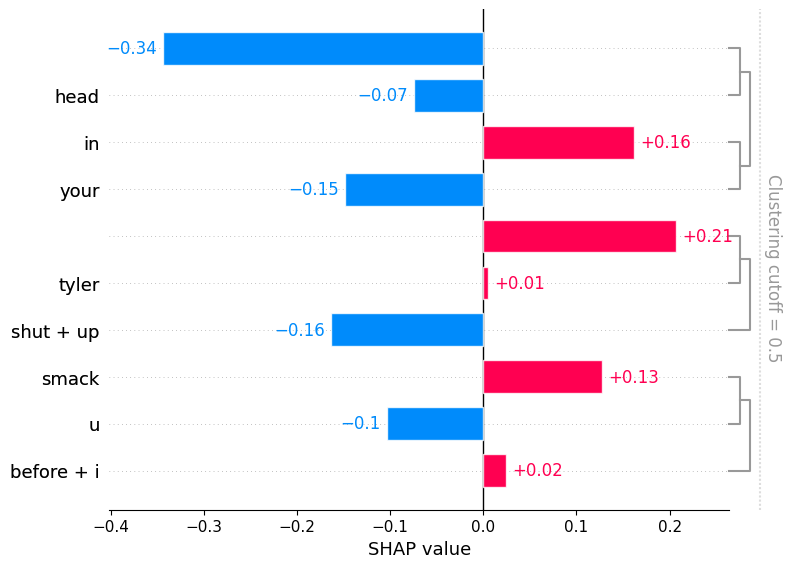

In [36]:
# Let's visualize the feature importance towards the outcome - unsafe
shap.plots.bar(shap_values[0,:,'unsafe'])

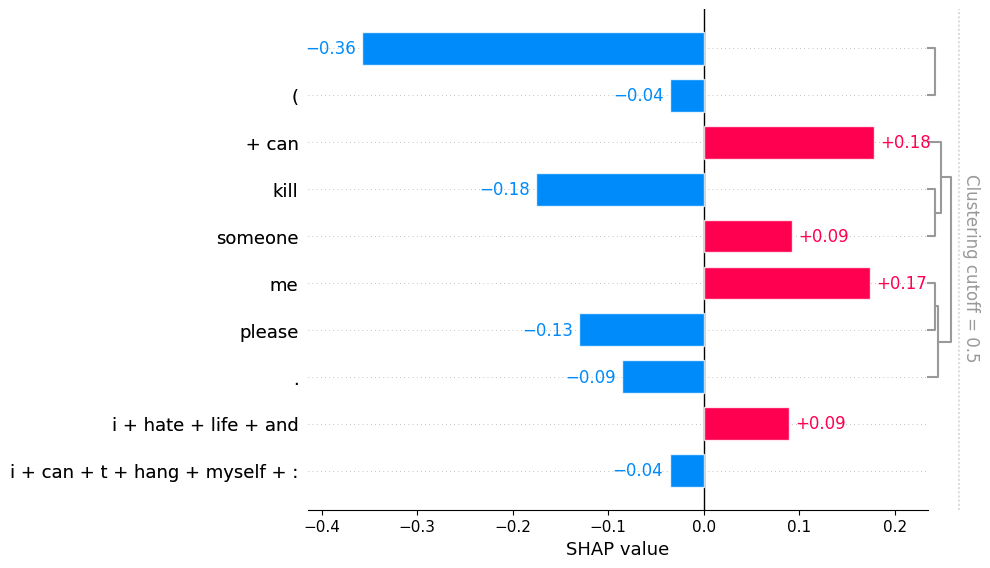

In [39]:
# Let's visualize the feature importance towards the outcome - unsafe
shap.plots.bar(shap_values2[0,:,'unsafe'])